In [278]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt

In [279]:
qs_2022 = pd.read_csv('C:/Users/alion/OneDrive/文件/GitHub/WUR-analysis/QS/qs_2022_refine.csv')
qs_2023 = pd.read_csv('C:/Users/alion/OneDrive/文件/GitHub/WUR-analysis/QS/qs_2023_refine.csv')
the_2022 = pd.read_csv('C:/Users/alion/OneDrive/文件/GitHub/WUR-analysis/THE/the_2022_refine.csv')
the_2023 = pd.read_csv('C:/Users/alion/OneDrive/文件/GitHub/WUR-analysis/THE/the_2023_refine.csv')

QS:

比較QS學生人數, 師生比, 國際學生人數, Status, Research Output, Size 是否影響 rank

In [280]:
lm = LinearRegression()
# 2022
X1 = qs_2022['Total students']
X2 = qs_2022['International students']
X3 = qs_2022['Total students'] / qs_2022['Total faculty staff']
X4 = qs_2022['Status'].map({'Private': 0, 'Public': 1})
X5 = qs_2022['Research Output'].map({'Very High': 3, 'High': 2, 'Medium': 1, 'Low': 0})
X6 = qs_2022['Size'].map({'M': 0, 'L': 1, 'S': 2, 'XL': 3})
X = pd.concat([X1, X2, X3, X4, X5, X6], axis = 1)
y = qs_2022['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.5551077325846112
(array([3], dtype=int64),)


由以上結果可知Status對排名影響不大，可以刪掉

In [281]:
X = pd.concat([X1, X2, X3, X5, X6], axis = 1)
y = qs_2022['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.5548729780593005
(array([], dtype=int64),)


In [282]:
reg.coef_

array([ 2.39444798e-03, -4.44204133e-02,  2.23656805e+01, -1.75985578e+02,
       -3.98072959e+01])

In [289]:
# 2023
X1 = qs_2023['Total students']
X2 = qs_2023['International students']
X3 = qs_2023['Total students'] / qs_2023['Total faculty staff']
X = pd.concat([X1, X2, X3], axis = 1)
y = qs_2023['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.4285086914125026
(array([], dtype=int64),)


In [290]:
reg.coef_

array([ 9.01684717e-04, -5.19852651e-02,  2.83543354e+01])

合併QS當年與前一年的資料

In [225]:
qs = pd.merge(qs_2023[['University', 'Total students', 'International students', 'Total faculty staff', 'Int\'l staff rate', 'Domestic staff rate', 'rank']], 
qs_2022[['University', 'Total students', 'International students', 'Total faculty staff', 'Int\'l staff rate', 'Domestic staff rate', 'Status', 'Research Output', 'Size', 'rank']], 
how = 'inner', on = 'University')

In [226]:
qs = qs.rename(columns={'Total students_x':'Total students_2023',
'International students_x':'International students_2023',
'Total faculty staff_x':'Total faculty staff_2023',
'Int\'l staff rate_x':'Int\'l staff rate_2023',
'Domestic staff rate_x':'Domestic staff rate_2023',
'rank_x':'rank_2023',
'Total students_y':'Total students_2022',
'International students_y':'International students_2022',
'Total faculty staff_y':'Total faculty staff_2022',
'Int\'l staff rate_y':'Int\'l staff rate_2022',
'Domestic staff rate_y':'Domestic staff rate_2022',
'rank_y':'rank_2022'})

比較QS學生人數增減, 師生比增減, 國際學生人數增減, Research Output, Size 是否影響 rank增減

In [227]:
students_growth = (qs['Total students_2023']-qs['Total students_2022']) / [max(qs['Total students_2023'][i], qs['Total students_2022'][i]) for i in range(len(qs['Total students_2022']))]
int_stud_growth = qs['International students_2023']/qs['Total students_2023'] - qs['International students_2022']/qs['Total students_2022']
staff_rate_growth = qs['Total students_2023']/qs['Total faculty staff_2023'] - qs['Total students_2022']/qs['Total faculty staff_2022']
rank_growth = qs['rank_2023'] - qs['rank_2022']

qs_compare = pd.concat([qs, students_growth, int_stud_growth, staff_rate_growth, rank_growth], axis = 1)
qs_compare = qs_compare.rename(columns = {0:'students_growth', 1:'int_stud_growth', 2:'staff_rate_growth', 3:'rank_growth'})

In [228]:
qs_less500 = qs_compare[(qs_compare['rank_2022'] <= 500) | (qs_compare['rank_2023'] <= 500)]

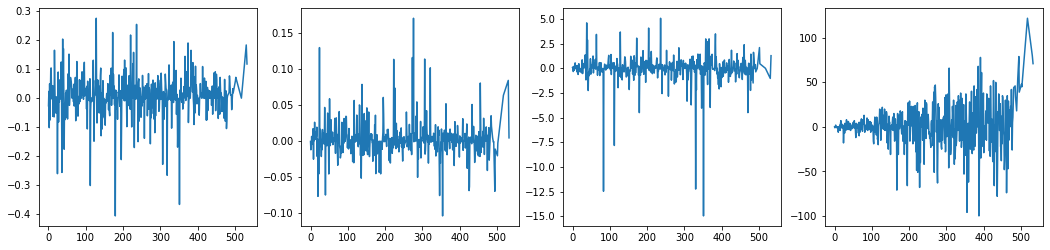

In [229]:
fig = plt.figure(figsize=(18, 4)) 
ax = fig.add_subplot(1, 4, 1)
plt.plot(qs_less500['students_growth'])
ax = fig.add_subplot(1, 4, 2)
plt.plot(qs_less500['int_stud_growth'])
ax = fig.add_subplot(1, 4, 3)
plt.plot(qs_less500['staff_rate_growth'])
ax = fig.add_subplot(1, 4, 4)
plt.plot(qs_less500['rank_growth'])
plt.show()

In [291]:
X1 = qs_less500['students_growth']
X2 = qs_less500['int_stud_growth']
X3 = qs_less500['staff_rate_growth']
X4 = qs_less500['Research Output'].map({'Very High': 3, 'High': 2, 'Medium': 1, 'Low': 0})
X5 = qs_less500['Size'].map({'M': 0, 'L': 1, 'S': 2, 'XL': 3})
X = pd.concat([X1, X2, X3, X4, X5], axis = 1)
y = qs_less500['rank_growth']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.10923619718223798
(array([2, 4], dtype=int64),)


In [292]:
X = pd.concat([X1, X2, X4], axis = 1)
y = qs_less500['rank_growth']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.10479151549287391
(array([], dtype=int64),)


In [293]:
reg.coef_

array([  65.05297873, -171.74122871,   11.29555563])

由以上結果可知在前500名內的資料中，staff_rate_growth, Size是對排名增減影響較小的資料，但模型並無法合理解釋排名增減的變異

THE:

比較THE學生人數, 師生比, 國際學生人數是否影響 rank

In [294]:
# 2023
X1 = the_2023['Total Students']
X2 = the_2023['Total Students'] * the_2023['pc of int\'l students']
X3 = the_2023['student staff ratio']
X = pd.concat([X1, X2, X3], axis = 1)
y = the_2023['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.25849529259774406
(array([2], dtype=int64),)


In [284]:
X = pd.concat([X1, X2], axis = 1)
y = the_2023['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.2583901008888583
(array([], dtype=int64),)


In [285]:
reg.coef_

array([ 0.00275555, -0.06989145])

In [286]:
# 2022
X1 = the_2022['Total Students']
X2 = the_2022['Total Students'] * the_2022['pc of int\'l students']
X3 = the_2022['student staff ratio']
X = pd.concat([X1, X2, X3], axis = 1)
y = the_2022['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.3054845810657355
(array([2], dtype=int64),)


In [287]:
X = pd.concat([X1, X2], axis = 1)
y = the_2022['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.30545360379790865
(array([], dtype=int64),)


In [288]:
reg.coef_

array([ 0.00314014, -0.0877322 ])

由以上結果可知師生比是對THE排名影響較小的資料，但即使刪去師生筆的資料模型仍無法合理解釋排名的變異

合併THE當年與前一年的資料

In [236]:
the = pd.merge(the_2023[['rank', 'University', 'Total Students', 'student staff ratio', 'pc of int\'l students']],
the_2022[['rank', 'University', 'Total Students', 'student staff ratio', 'pc of int\'l students']],
how = 'inner', on = 'University')

In [237]:
the = the.rename(columns={'rank_x':'rank_2023', 'Total Students_x':'Total Students_2023',
'student staff ratio_x':'student staff ratio_2023',
'pc of int\'l students_x':'pc of int\'l students_2023',
'rank_y':'rank_2022', 'Total Students_y':'Total Students_2022',
'student staff ratio_y':'student staff ratio_2022',
'pc of int\'l students_y':'pc of int\'l students_2022'})

In [241]:
students_growth = (the['Total Students_2023']-the['Total Students_2022']) / [max(the['Total Students_2023'][i], the['Total Students_2022'][i]) for i in range(len(the['Total Students_2022']))]
int_stud_growth = the['pc of int\'l students_2023'] - the['pc of int\'l students_2022']
staff_rate_growth = the['student staff ratio_2023'] - the['student staff ratio_2022']
rank_growth = the['rank_2023'] - the['rank_2022']

the_compare = pd.concat([the, students_growth, int_stud_growth, staff_rate_growth, rank_growth], axis = 1)
the_compare = the_compare.rename(columns = {0:'students_growth', 1:'int_stud_growth', 2:'staff_rate_growth', 3:'rank_growth'})

In [242]:
the_compare

,rank_2023,University,Total Students_2023,student staff ratio_2023,pc of int'l students_2023,rank_2022,Total Students_2022,student staff ratio_2022,pc of int'l students_2022,students_growth,int_stud_growth,staff_rate_growth,rank_growth
0,1,University of Oxford,20967,10.6,0.42,1,20835,10.7,0.42,0.006296,0.00,-0.1,0
1,2,Harvard University,21887,9.6,0.25,2,21574,9.5,0.24,0.014301,0.01,0.1,0
2,3,University of Cambridge,20185,11.3,0.39,5,19681,11.1,0.39,0.024969,0.00,0.2,-2
3,3,Stanford University,16164,7.1,0.24,4,16319,7.3,0.23,-0.009498,0.01,-0.2,-1
4,5,Massachusetts Institute of Technology,11415,8.2,0.33,5,11459,8.4,0.33,-0.003840,0.00,-0.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,1350,Pontifical Catholic University of Peru,25644,7.8,0.01,1100,26809,7.1,0.02,-0.043456,-0.01,0.7,250
1189,1350,Pontifical Catholic University of Valparaiso,17703,26.6,0.01,1100,17411,25.4,0.01,0.016494,0.00,1.2,250
1190,1350,Pontificia Universidade Catolica do Parana,12301,14.7,0.01,1100,13324,14.9,0.01,-0.076779,0.00,-0.2,250
1191,1350,University of Primorska,6089,16.6,0.15,1100,5149,15.1,0.14,0.154377,0.01,1.5,250


In [245]:
the_less500 = the_compare[(the_compare['rank_2022'] <= 500) | (the_compare['rank_2023'] <= 500)]

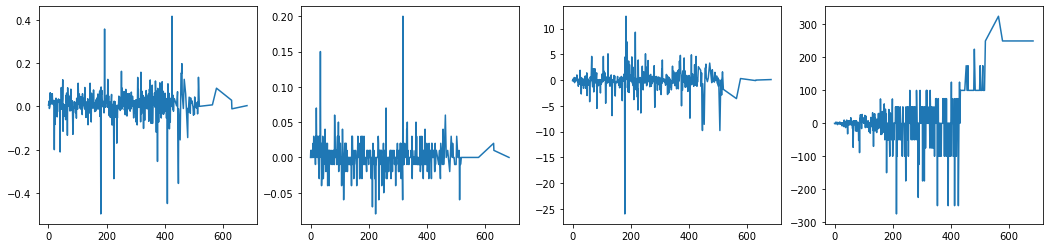

In [247]:
fig = plt.figure(figsize=(18, 4)) 
ax = fig.add_subplot(1, 4, 1)
plt.plot(the_less500['students_growth'])
ax = fig.add_subplot(1, 4, 2)
plt.plot(the_less500['int_stud_growth'])
ax = fig.add_subplot(1, 4, 3)
plt.plot(the_less500['staff_rate_growth'])
ax = fig.add_subplot(1, 4, 4)
plt.plot(the_less500['rank_growth'])
plt.show()

In [248]:
X1 = the_less500['students_growth']
X2 = the_less500['int_stud_growth']
X3 = the_less500['staff_rate_growth']
X = pd.concat([X1, X2, X3], axis = 1)
y = the_less500['rank_growth']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.02252832906512492
(array([1], dtype=int64),)


In [249]:
X = pd.concat([X1, X3], axis = 1)
y = the_less500['rank_growth']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', 1-R2)

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X.iloc[:,i] - X.iloc[:,i].mean())**2).sum() ) for i in range(X.shape[1])]
print(np.where(abs(reg.coef_ / se_b) < stats.t.ppf(0.95, df = len(y)-2)))

R square score = 0.02102896779778851
(array([], dtype=int64),)


由上述的分析結果可以知道
- QS的資料較能解釋排名的變異
在觀察QS的資料時我們發現
- 學生人數, 師生比, 國際學生人數, Research Output, Size 對排名影響較大
- 學生人數增減, 國際學生人數增減, Research Output 對排名增減影響較大, 但模型解釋能力不好
在觀察THE的資料時我們發現
- 學生人數, 國際學生人數 對排名影響較大, 但模型解釋能力不好

近年來, 兩個機構間學生人數對排名的影響的差異以減少, 因此為了不同排名機構而報不同學生人數的現象也會因此減少

合併QS, THE

In [295]:
merge_table = pd.merge(the, qs, how = 'outer', on = 'University')

In [296]:
print('QS的學校,但和THE對不起來共有', len(merge_table[merge_table['rank_2023_x'].isna()]['University']), '所')

QS的學校,但和THE對不起來共有 580 所


In [297]:
print('THE的學校,但和THE對不起來共有', len(merge_table[merge_table['rank_2023_y'].isna()]['University']), '所')

THE的學校,但和THE對不起來共有 620 所


In [309]:
merge_inner = pd.merge(the, qs, how = 'inner', on = 'University')

In [310]:
merge_inner = merge_inner.drop(['Status', 'Research Output', 'Size','Int\'l staff rate_2023', 'Domestic staff rate_2023', 'Int\'l staff rate_2022', 'Domestic staff rate_2022'], axis = 1)

In [311]:
merge_inner = merge_inner.rename(columns={'rank_2023_x':'rank_2023_the', 'Total Students_2023':'Total students_2023_the',
'student staff ratio_2023': 'student staff ratio_2023_the', 'pc of int\'l students_2023':'pc of int\'l students_2023_the',
'rank_2022_x': 'rank_2022_the', 'Total Students_2022':'Total students_2022_the',
'student staff ratio_2022': 'student staff ratio_2022_the', 'pc of int\'l students_2022':'pc of int\'l students_2022_the', 
'Total students_2023':'Total students_2023_qs', 'International students_2023':'International students_2023_qs',
'Total faculty staff_2023':'Total faculty staff_2023_qs', 'rank_2023_y':'rank_2023_qs',
'Total students_2022':'Total students_2022_qs', 'International students_2022':'International students_2022_qs',
'Total faculty staff_2022':'Total faculty staff_2022_qs', 'rank_2022_y':'rank_2022_qs'})

In [312]:
merge_inner

,rank_2023_the,University,Total students_2023_the,student staff ratio_2023_the,pc of int'l students_2023_the,rank_2022_the,Total students_2022_the,student staff ratio_2022_the,pc of int'l students_2022_the,Total students_2023_qs,International students_2023_qs,Total faculty staff_2023_qs,rank_2023_qs,Total students_2022_qs,International students_2022_qs,Total faculty staff_2022_qs,rank_2022_qs
0,1,University of Oxford,20967,10.6,0.42,1,20835,10.7,0.42,21972,9024,6650,4,20889,8442,6708,2
1,2,Harvard University,21887,9.6,0.25,2,21574,9.5,0.24,21877,5379,4480,5,23663,5877,4646,5
2,3,University of Cambridge,20185,11.3,0.39,5,19681,11.1,0.39,20871,7865,5735,2,20383,7925,5800,3
3,3,Stanford University,16164,7.1,0.24,4,16319,7.3,0.23,14518,3318,4694,3,16164,3879,4725,3
4,5,Massachusetts Institute of Technology,11415,8.2,0.33,5,11459,8.4,0.33,11035,3627,2919,1,11333,3730,3065,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,1350,National Research Saratov State University,9826,9.3,0.11,1350,9746,9.1,0.11,9336,1306,1718,555,10153,1109,1718,535
569,1350,Slovak University of Agriculture in Nitra,4870,11.3,0.03,1350,5326,12.7,0.03,5610,165,430,1300,5610,163,430,1100
570,1350,University of Ostrava,8492,16.4,0.11,1350,8570,16.8,0.10,6935,679,564,1100,6935,679,564,1100
571,1350,Pontificia Universidade Catolica do Parana,12301,14.7,0.01,1100,13324,14.9,0.01,10370,117,721,1300,10556,141,758,1300


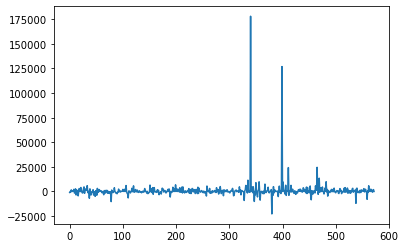

In [314]:
plt.plot(merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'])

In [322]:
diff2023 = merge_inner[abs(merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs']) > 10000]
print('共有', diff2023.shape[0], '間大學2023年兩個機構的人數差距>10000')
print(list(diff2023['University']))

共有 10 間大學2023年兩個機構的人數差距>10000
['University of Vienna', 'University of Colombo', 'University of Dhaka', 'Hacettepe University', 'Universite du Quebec', 'Al-Azhar University', 'Cairo University', 'Assiut University', 'Charles Sturt University', 'Universidade do Estado do Rio de Janeiro']


In [323]:
the_more_than_qs_2023 = merge_inner[merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'] > 10000]
print('共有', the_more_than_qs_2023.shape[0], '間大學2023年THE-QS人數>10000')
print(list(the_more_than_qs_2023['University']))

共有 6 間大學2023年THE-QS人數>10000
['University of Colombo', 'University of Dhaka', 'Al-Azhar University', 'Cairo University', 'Assiut University', 'Charles Sturt University']


In [324]:
qs_more_than_the_2023 = merge_inner[merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'] < -10000]
print('共有', qs_more_than_the_2023.shape[0], '間大學2023年QS-THE人數>10000')
print(list(qs_more_than_the_2023['University']))

共有 4 間大學2023年THE-QS人數>10000
['University of Vienna', 'Hacettepe University', 'Universite du Quebec', 'Universidade do Estado do Rio de Janeiro']


In [325]:
diff2022 = merge_inner[abs(merge_inner['Total students_2022_the'] - merge_inner['Total students_2022_qs']) > 10000]
print('共有', diff2022.shape[0], '間大學2022年兩個機構的人數差距>10000')
print(list(diff2022['University']))

共有 11 間大學2022年兩個機構的人數差距>10000
['University of Southern California', 'University of Vienna', 'Banaras Hindu University', 'University of Dhaka', 'Universite du Quebec', 'Al-Azhar University', 'Cairo University', 'Assiut University', 'Charles Sturt University', 'Universidade do Estado do Rio de Janeiro', 'Marmara University']


In [326]:
the_more_than_qs_2022 = merge_inner[merge_inner['Total students_2022_the'] - merge_inner['Total students_2022_qs'] > 10000]
print('共有', the_more_than_qs_2022.shape[0], '間大學2022年THE-QS人數>10000')
print(list(the_more_than_qs_2022['University']))

共有 8 間大學2022年THE-QS人數>10000
['University of Southern California', 'University of Dhaka', 'Universite du Quebec', 'Al-Azhar University', 'Cairo University', 'Assiut University', 'Charles Sturt University', 'Marmara University']


In [327]:
qs_more_than_the_2022 = merge_inner[merge_inner['Total students_2022_the'] - merge_inner['Total students_2022_qs'] < -10000]
print('共有', qs_more_than_the_2022.shape[0], '間大學2022年QS-THE人數>10000')
print(list(qs_more_than_the_2022['University']))

共有 3 間大學2022年QS-THE人數>10000
['University of Vienna', 'Banaras Hindu University', 'Universidade do Estado do Rio de Janeiro']
